In [27]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
stats = ['Base', 'Advanced', 'Four%20Factors', 'Misc', 'Scoring']
headers = {
        'accept':'*/*',
        'accept-encoding':'gzip, deflate, br, zstd',
        'accept-language':'fr,fr-FR;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6,fr-CH;q=0.5',
        'connection':'keep-alive',
        'host':'stats.nba.com',
        'origin':'https://www.nba.com',
        'referer':'https://www.nba.com/',
        'sec-ch-ua':'"Chromium";v="128", "Not;A=Brand";v="24", "Microsoft Edge";v="128"',
        'sec-ch-ua-mobile':'?0',
        'sec-ch-ua-platform':'"Windows"',
        'sec-fetch-dest':'empty',
        'sec-fetch-mode':'cors',
        'sec-fetch-site':'same-site',
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'
}



all_dfs = []

for stat in stats:
    url = f'https://stats.nba.com/stats/teamgamelogs?DateFrom=&DateTo=&GameSegment=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType={stat}&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlusMinus=N&Rank=N&Season=2023-24&SeasonSegment=&SeasonType=Regular%20Season&ShotClockRange=&VsConference=&VsDivision='
    r = requests.get(url, headers=headers).json()
    
    data = r['resultSets'][0]['rowSet']
    col_names = r['resultSets'][0]['headers']  # Récupération des bonnes colonnes pour chaque stat
    
    df_temp = pd.DataFrame(data, columns=col_names)
    all_dfs.append(df_temp)

df_final = all_dfs[0]
for df in all_dfs[1:]:
    df_final = df_final.merge(df, on=['GAME_ID', 'TEAM_ID'], how='outer', suffixes=('', '_dup'))

# Supprimer les colonnes dupliquées
df = df_final.loc[:, ~df_final.columns.str.endswith('_dup')]
df = df.loc[:, ~df.columns.str.endswith('RANK')]

In [3]:
df_final = df.drop(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN'], axis=1)

In [4]:
pd.set_option('display.max_rows', None)  # Affiche toutes les lignes (colonnes dans ce cas)
print(df.dtypes)
pd.reset_option('display.max_rows')  # Réinitialise l'option après affichage
# Toutes les colonnes ont des dtypes int64 ou float64

SEASON_YEAR            object
TEAM_ID                 int64
TEAM_ABBREVIATION      object
TEAM_NAME              object
GAME_ID                object
GAME_DATE              object
MATCHUP                object
WL                     object
MIN                   float64
FGM                     int64
FGA                     int64
FG_PCT                float64
FG3M                    int64
FG3A                    int64
FG3_PCT               float64
FTM                     int64
FTA                     int64
FT_PCT                float64
OREB                    int64
DREB                    int64
REB                     int64
AST                     int64
TOV                   float64
STL                     int64
BLK                     int64
BLKA                    int64
PF                      int64
PFD                     int64
PTS                     int64
PLUS_MINUS            float64
AVAILABLE_FLAG          int64
E_OFF_RATING          float64
OFF_RATING            float64
E_DEF_RATI

In [5]:
corr_mat = df_final.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,...,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
FGM,0.000000,0.441066,0.790219,0.361830,0.056803,0.421624,-0.163987,-0.173773,-0.017650,0.016621,...,0.086137,-0.457902,-0.071497,0.194995,0.042955,-0.042905,-0.068464,0.068498,-0.013140,0.013117
FGA,0.441066,0.000000,-0.196553,0.114927,0.366341,-0.147691,-0.238017,-0.238162,-0.054569,0.543572,...,0.124177,-0.343663,0.014738,0.199525,-0.079341,0.079379,-0.058732,0.058750,-0.113884,0.113887
FG_PCT,0.790219,-0.196553,0.000000,0.316183,-0.186109,0.562594,-0.015900,-0.026135,0.016923,-0.344753,...,0.010998,-0.267475,-0.086201,0.078856,0.100099,-0.100069,-0.035562,0.035587,0.061776,-0.061807
FG3M,0.361830,0.114927,0.316183,0.000000,0.654216,0.773635,-0.169015,-0.176437,-0.019728,-0.059871,...,-0.045565,-0.342980,-0.070954,-0.671324,0.044399,-0.044429,-0.068323,0.068591,0.265372,-0.265389
FG3A,0.056803,0.366341,-0.186109,0.654216,0.000000,0.047059,-0.214708,-0.213290,-0.049387,0.152117,...,0.008682,-0.266574,-0.030073,-0.460989,0.029706,-0.029718,-0.015983,0.016169,0.210959,-0.210965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCT_UAST_2PM,-0.042905,0.079379,-0.100069,-0.044429,-0.029718,-0.036036,0.052191,0.045709,0.023904,0.165551,...,-0.098586,0.058564,0.000827,-0.049560,-0.999999,0.000000,-0.096245,0.096313,-0.873245,0.873240
PCT_AST_3PM,-0.068464,-0.058732,-0.035562,-0.068323,-0.015983,-0.071402,-0.016103,-0.011828,-0.016806,0.018912,...,0.020689,0.010482,0.035857,0.048602,0.096236,-0.096245,0.000000,-0.999999,0.445899,-0.445891
PCT_UAST_3PM,0.068498,0.058750,0.035587,0.068591,0.016169,0.071613,0.016041,0.011759,0.016799,-0.018915,...,-0.020666,-0.010582,-0.035811,-0.048808,-0.096303,0.096313,-0.999999,0.000000,-0.445862,0.445854
PCT_AST_FGM,-0.013140,-0.113884,0.061776,0.265372,0.210959,0.182194,-0.079556,-0.074134,-0.026734,-0.154239,...,0.065587,-0.089185,-0.000724,-0.170685,0.873222,-0.873245,0.445899,-0.445862,0.000000,-1.000000


In [6]:
# Voir les features les plus corrélées entre elles
corr_mat.abs().idxmax()

FGM                      PTS
FGA                     OREB
FG_PCT               EFG_PCT
FG3M             PCT_PTS_3PT
FG3A             PCT_FGA_2PT
                    ...     
PCT_UAST_2PM     PCT_AST_2PM
PCT_AST_3PM     PCT_UAST_3PM
PCT_UAST_3PM     PCT_AST_3PM
PCT_AST_FGM          AST_PCT
PCT_UAST_FGM         AST_PCT
Length: 70, dtype: object

In [7]:
# Seulement deux colonnes avec un skew au-dessus de 0.75
log_columns = df_final.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

AST_TO            2.176819
PCT_PTS_2PT_MR    0.860426
dtype: float64

In [8]:
# On utilise la log transformations pour avoir des data mieux distribuées
for col in log_columns.index:
    df_final[col] = np.log1p(df_final[col])

In [9]:
# Utiliser MinMax pour scaler les données afin que nos modèles de unsupervised learning ne soient pas influencées par le poids de certaines données
mms = MinMaxScaler()

for col in df_final.columns:
    df_final[col] = mms.fit_transform(df_final[[col]]).squeeze()

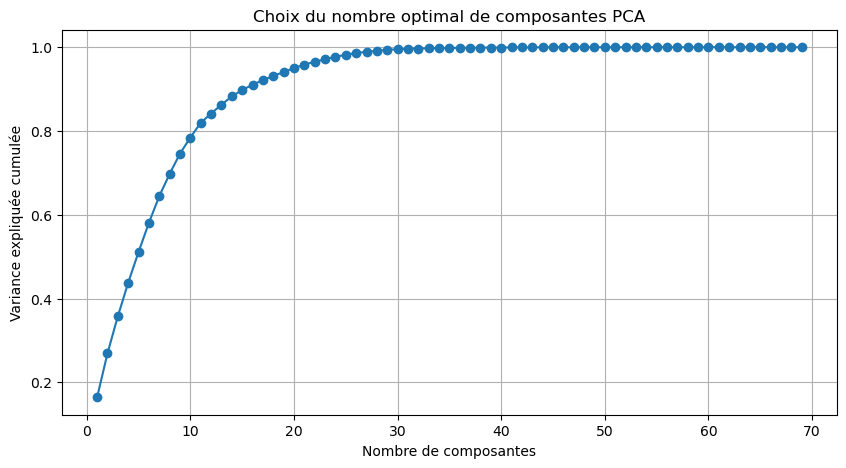

In [13]:
pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 70):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n, svd_solver="randomized", random_state=42)
    PCAmod.fit(df_final)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': df_final.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')

plt.figure(figsize=(10, 5))
plt.plot(pca_df.index, pca_df["var"], marker='o', linestyle='-')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Choix du nombre optimal de composantes PCA")
plt.grid()
plt.show()

In [22]:
# Appliquer la PCA avec le nombre optimal de composantes
PCAmod_final = PCA(n_components=30)
data_pca = PCAmod_final.fit_transform(df_final)

# Convertir les données PCA en DataFrame
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
data_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,-0.073853,0.303127,0.240074,0.555455,-0.010865,0.564080,-0.036437,0.134720,-0.151973,-0.012997,...,0.055695,-0.005303,0.029816,0.127656,-0.039314,-0.045112,-0.091225,0.005886,-0.000176,0.049236
1,0.155188,0.147914,0.103408,0.038117,0.323471,-0.343404,0.096364,0.363539,0.221150,-0.245181,...,0.171182,0.113263,0.152144,0.007790,0.016040,-0.080675,0.073037,-0.011161,-0.110685,0.019931
2,0.164224,-0.528957,-0.252666,-0.534051,0.564001,0.023379,-0.170993,-0.056339,-0.432122,0.287333,...,-0.297554,0.022788,-0.044346,-0.049541,0.014221,-0.048630,0.070927,0.047653,-0.087442,-0.068736
3,-0.598649,0.446916,-0.147081,-0.523180,-0.091846,-0.214793,0.226913,-0.432649,-0.155718,-0.244850,...,0.166150,0.094996,-0.196764,0.059305,-0.128669,0.028328,-0.129888,0.057931,0.005485,0.060583
4,0.500933,-0.080030,0.349827,0.339976,0.062370,-0.142963,-0.077824,0.728588,0.076282,-0.523803,...,-0.012440,0.025858,0.059660,0.028408,0.143518,-0.014934,-0.107418,0.041791,0.132713,0.047508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,0.015205,0.065338,-0.199572,-0.306252,-0.063605,-0.386031,0.061787,-0.118792,-0.164004,-0.115731,...,0.004469,-0.012361,-0.087285,-0.014578,0.045250,0.068326,-0.029153,0.019931,0.083501,-0.023244
2456,-0.471643,0.607055,-0.504539,0.160582,0.255264,-0.144051,0.220517,0.014466,-0.123308,0.422684,...,-0.051702,-0.070324,0.055580,-0.046560,-0.058465,-0.142998,0.038157,0.041823,-0.066552,0.026566
2457,0.085767,0.809741,0.088516,0.374706,-0.168534,-0.132017,0.179265,-0.257371,-0.146304,0.303274,...,0.069632,-0.004132,0.128118,-0.088708,-0.189891,0.025136,0.015858,0.012731,0.021474,-0.022338
2458,-1.108254,-0.201917,0.301680,0.422171,-0.084247,-0.122762,0.252224,-0.161527,-0.166744,-0.105300,...,-0.187104,0.029295,0.019802,-0.121687,-0.076591,0.040017,-0.058719,0.007479,-0.011299,0.060953


In [26]:
feature_weights = pd.DataFrame(PCAmod_final.components_, columns=df_final.columns)

# Afficher les poids des features pour la première composante
top_features = feature_weights.T.sort_values(by=0, ascending=False).head(20)
top_features

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
EFG_PCT,0.259921,0.015040,-0.106762,0.062507,0.022940,0.009272,-0.062202,0.212635,0.008789,-0.042103,...,0.100705,0.061615,0.010745,0.051231,-0.052961,0.040002,-0.034556,0.037500,0.071606,0.044457
E_OFF_RATING,0.258203,0.069731,-0.173004,0.066576,-0.004215,-0.011894,-0.068615,-0.026267,0.075077,-0.028256,...,-0.013141,-0.046786,-0.032907,-0.017597,-0.116357,-0.026203,-0.087891,0.104155,0.220558,-0.021153
PTS,0.253468,0.133439,-0.113081,0.128055,0.097892,-0.048577,0.049708,-0.038233,0.048893,0.002603,...,0.031611,-0.061017,-0.030249,-0.018357,0.093506,0.111676,-0.055428,0.035521,-0.178022,-0.063499
OFF_RATING,0.252934,0.071069,-0.173414,0.067358,-0.008805,-0.025439,-0.060200,-0.032431,0.101083,-0.019433,...,0.037635,-0.004073,-0.037098,-0.027410,-0.052174,-0.062233,0.053988,-0.069866,-0.010510,-0.006929
AST_RATIO,0.237149,-0.132546,0.104343,0.134283,-0.077056,-0.022603,-0.047251,0.023846,-0.004439,-0.011897,...,0.038744,0.027693,0.018863,-0.006947,-0.001799,0.004383,0.016076,-0.001498,0.057975,-0.010254
TS_PCT,0.233966,0.031155,-0.105842,0.060065,0.078873,0.023580,-0.107580,0.160513,0.013188,-0.045843,...,0.027208,0.058098,0.006537,0.044006,-0.032949,0.048511,-0.032362,0.036076,0.063467,0.041411
FG_PCT,0.219984,0.082118,-0.064269,0.112988,-0.021365,0.003390,-0.107749,0.212768,0.004433,-0.042573,...,0.129971,0.066408,0.009972,0.051510,-0.058022,0.042627,-0.038968,0.040364,0.070809,0.039654
E_NET_RATING,0.219749,0.124951,0.024812,-0.140542,-0.020236,0.076377,-0.062833,-0.016761,-0.002439,0.035362,...,0.001241,-0.028932,-0.003497,-0.030433,-0.032218,-0.085321,-0.110140,0.018352,0.117577,-0.021771
AST,0.216907,-0.079951,0.121173,0.140305,-0.032758,-0.061346,0.027062,-0.014047,0.035192,0.016182,...,0.031844,-0.019170,-0.020947,-0.000169,0.056472,0.047168,-0.008023,0.010596,-0.066265,-0.024780
NET_RATING,0.212171,0.123565,0.027250,-0.140644,-0.023626,0.054079,-0.050701,-0.019181,0.009703,0.015243,...,0.033161,0.000234,0.004540,-0.030816,0.005384,-0.100818,0.004737,-0.007213,-0.049495,-0.139435


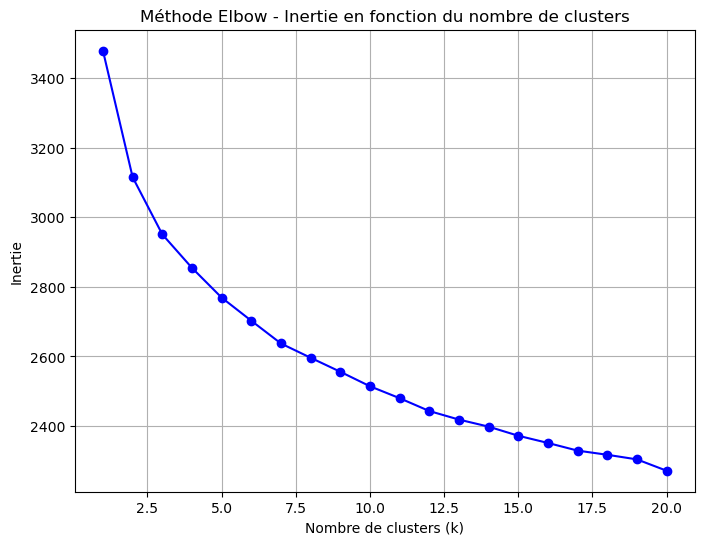

"\nOn ne voit un coude bien se dessiner mais on peut estimer qu'entre 5 à 8 clusters sont largement efficaces pour notre modèles de unsupervised learning.\nNous sommes passés de 70 à 30 dimensions avec PCA et \non a trouvé le nombre de clusters optimals qui se situe entre 5 et 8 pour ce projet de catégoriser les performences des équipes NBA \nlors de la saison 23-24.\n"

In [30]:
# Définir une plage de valeurs de k à tester
k_range = range(1, 21)  # Tester de k = 1 à k = 10 par exemple

# Liste pour stocker l'inertie pour chaque k
inertia_list = []

# Appliquer K-means pour chaque k dans la plage
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)  # Utiliser les données PCA transformées
    inertia_list.append(kmeans.inertia_)  # Stocker l'inertie (somme des carrés des distances)

# Tracer la courbe de l'inertie
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia_list, marker='o', linestyle='-', color='b')
plt.title('Méthode Elbow - Inertie en fonction du nombre de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.grid(True)
plt.show()

"""
On ne voit un coude bien se dessiner mais on peut estimer qu'entre 5 à 8 clusters sont largement efficaces pour notre modèles de unsupervised learning.
Nous sommes passés de 70 à 30 dimensions avec PCA et 
on a trouvé le nombre de clusters optimals qui se situe entre 5 et 8 pour ce projet de catégoriser les performences des équipes NBA 
lors de la saison 23-24.
"""